### **Study Buddy AI: Your Personalized Study Assistant**

<!-- ##### **Description:**
Study Buddy AI is an intelligent assistant designed to revolutionize the way students learn and plan their studies. Equipped with advanced features like personalized study plans, web search for research, math problem-solving, and human-in-the-loop assistance, it ensures accurate, actionable, and tailored support for academic success. Leveraging memory and contextual knowledge, Study Buddy AI creates dynamic, efficient schedules and provides step-by-step explanations to help students master any subject with ease. -->

##### **Current Features:**

- **Tool Assistance**: Integrates with tools like Study Scheduler and Web Search.
- **Personalized Support**: Remembers user-specific details such as exam dates, preferred study times, and past topics to deliver customized responses.
- **Study Schedule Creation**: Automatically generates optimized study plans based on deadlines, topics, and available time.
- **User-Friendly Interaction**: Polite, clear, and concise responses with follow-up questions to ensure clarity.


### DEPENDENCIES


In [ ]:
%pip install -q -U google-generativeai langchain-google-genai langgraph langchain langchain-core pydantic tavily-python langchain_community langgraph-checkpoint-sqlite chromadb langchain-text-splitters pypdf rapidocr-onnxruntime

In [1]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GOOGLE_API_KEY")
_set_env("TAVILY_API_KEY")
# _set_env("LANGCHAIN_API_KEY")
# _set_env("LANGCHAIN_PROJECT")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [188]:
from typing import Optional, List, Annotated, Any, Dict, Union, Literal, Type
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, ConfigDict
from datetime import datetime, timedelta
import csv
import uuid
import json
import sqlite3

from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition, InjectedState, InjectedStore
from langgraph.types import Command, interrupt

from langgraph.checkpoint.sqlite import SqliteSaver

from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import (
    DirectoryLoader,
    TextLoader,
    PyPDFLoader,
    CSVLoader,
)
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter, Language

from langchain.prompts import ChatPromptTemplate, PromptTemplate, MessagesPlaceholder
from langchain.output_parsers import PydanticOutputParser
from langchain.schema import Document

from langchain_core.tools import tool, InjectedToolArg
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.runnables.config import RunnableConfig
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    SystemMessage,
    HumanMessage,
    AIMessage,
    AnyMessage,
    RemoveMessage,
    ToolMessage,
    AIMessageChunk,
)

from IPython.display import Image, clear_output, Markdown

### USER


In [348]:
# We would generally get the user_id from the authenticated User
user_id = str(uuid.uuid4())

### UTILS


In [413]:
def invoke_chat_template(
    model: BaseChatModel,
    template: str,
    template_data: dict[str, Any],
) -> BaseMessage:
    """Invoke the chat template with the provided tenplate data and return the response."""
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model
    result = chain.invoke(template_data)
    return result


def stream_agent(
    agent: CompiledStateGraph,
    input_value: Dict | List[Dict],
    config: RunnableConfig,
    debug: bool = False,
):
    """
    A function to interact with an agent in a streaming manner, handling updates and messages
    during the stream. The function facilitates communication with the agent by providing
    answers to questions when prompted and displaying messages based on specific conditions.

    Args:
        agent (CompiledStateGraph):
            The compiled state graph representing the agent's behavior or knowledge graph.
            This is used to drive the state transitions and handle the stream processing.

        input_value (Dict | List[Dict]):
            The input data that is passed to the agent. This can either be a single dictionary or
            a list of dictionaries. These inputs are processed by the agent to generate stream outputs.

        config (RunnableConfig):
            The configuration object that governs how the agent runs. This may include settings
            related to execution parameters, logging, error handling, and any other agent-specific configurations.

        debug (bool):
            If True, enables detailed logging for debugging purposes.

    Returns:
        None: This function is designed to interact with the agent and display messages interactively.
              It doesn't return a value but may perform side effects such as displaying output.
    """
    message = ""
    for stream_mode, data in agent.stream(
        input=input_value,
        config=config,
        stream_mode=["updates", "messages"],
        debug=debug,
    ):
        interrupt = (
            data.get("__interrupt__", None)
            if isinstance(data, dict) and stream_mode == "updates"
            else None
        )

        if stream_mode == "updates" and interrupt and len(interrupt) > 0:
            questions = interrupt[0].value
            questions_with_ans = []
            for question in questions:
                user_input = input(question.get("question", ""))

                questions_with_ans.append({**question, "answer": user_input})

            stream_agent(
                agent=agent,
                config=config,
                input_value=Command(resume=questions_with_ans),
            )

        elif (
            stream_mode == "messages"
            and data[-1].get("langgraph_node") == "handle_user_query"
            and data[0].content
            and isinstance(data[0], (AIMessage, AIMessageChunk))
        ):
            message += data[0].content  # Append content without a newline
            clear_output(True)
            display(Markdown(message))  # Display the message as Markdown


def load_and_split_documents(
    docs_folder: str,
    file_extension: str,
    chunk_size: int = 500,
    chunk_overlap: int = 50,
    loader_cls=None,
    loader_kwargs=None,
    text_splitter_language=Language.MARKDOWN,
    disable_splitter: bool = False,
    metadata: dict = None,
) -> list[Document]:
    """
    Load and split documents from a directory, based on file extension.

    Args:
    - docs_folder (str): Path to the folder containing documents.
    - file_extension (str): The file extension to match (e.g., '.txt', '.pdf').
    - chunk_size (int): The size of each chunk for text splitting.
    - chunk_overlap (int): The overlap size for text splitting.
    - loader_cls (class): The class to use for loading files (TextLoader or PyPDFLoader).
    - loader_kwargs (dict): Additional arguments for the loader class.
    - text_splitter_language (Language): The language setting for text splitting.
    - disable_splitter (bool): For Disabling Splitter. defaults to False
    - metadata (dict): Additional metadata for docs. defaults to None

    Returns:
    - List of split document chunks.
    """
    if loader_kwargs is None:
        loader_kwargs = {}

    # Define a text splitter with the chosen language
    text_splitter = (
        RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
        )
        if disable_splitter
        else RecursiveCharacterTextSplitter.from_language(
            language=text_splitter_language,
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
        )
    )

    # Initialize directory loader
    file_loader = DirectoryLoader(
        path=docs_folder,
        glob=f"**/*{file_extension}",
        show_progress=True,
        silent_errors=True,
        loader_cls=loader_cls,
        loader_kwargs=loader_kwargs,
    )

    # Load and split documents
    loaded_docs = file_loader.load_and_split(text_splitter)

    docs = (
        [
            Document(
                **doc.model_dump(exclude="metadata"),
                metadata={**doc.metadata, **metadata},
            )
            for doc in loaded_docs
        ]
        if metadata
        else loaded_docs
    )

    return docs

### MODELS


In [414]:
# MODEL_NAME = "gemini-1.5-flash"
MODEL_NAME = "gemini-2.0-flash-exp"
EMBEDDING_MODEL_NAME = "models/embedding-001"

model = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0)
embedding_model = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL_NAME)

### RAG


#### Documents


In [6]:
# Define a TypedDict for each file type configuration
class FileConfig(TypedDict):
    type: str  # File extension, e.g., ".txt", ".pdf"
    loader: Type  # The loader class, e.g., TextLoader, PyPDFLoader
    text_splitter_language: Language  # The language for the text splitter
    loader_kwargs: dict  # Additional keyword arguments for the loader class
    disable_splitter: bool

In [7]:
# Configuring the file types and their respective loaders and text splitter languages
supported_files_configs: List[FileConfig] = [
    {
        "type": ".txt",
        "loader": TextLoader,
        "text_splitter_language": Language.MARKDOWN,
        "loader_kwargs": {"autodetect_encoding": True},
        "metadata": {"user_id": str(user_id)},
    },
    {
        "type": ".md",
        "loader": TextLoader,
        "text_splitter_language": Language.MARKDOWN,
        "loader_kwargs": {"autodetect_encoding": True},
        "metadata": {"user_id": str(user_id)},
    },
    {
        "type": ".pdf",
        "loader": PyPDFLoader,
        "text_splitter_language": Language.MARKDOWN,
        "loader_kwargs": {"extract_images": True},
        "metadata": {"user_id": str(user_id)},
    },
    {
        "type": ".csv",
        "loader": CSVLoader,
        "disable_splitter": True,
        "metadata": {"user_id": str(user_id)},
    },
]

In [8]:
# Example of using the function for various file types (text and PDF):
docs_folder = "./docs"
docs = []

# Loop through each file configuration and load the corresponding documents
for config in supported_files_configs:
    file_extension = config["type"]
    loader_cls = config["loader"]
    text_splitter_language = config.get("text_splitter_language")
    loader_kwargs = config.get("loader_kwargs", {})
    metadata = config.get("metadata", None)
    disable_splitter = config.get("disable_splitter", None)

    # Load and split documents for the current file type
    docs += load_and_split_documents(
        docs_folder=docs_folder,
        file_extension=file_extension,
        loader_cls=loader_cls,
        loader_kwargs=loader_kwargs,
        text_splitter_language=text_splitter_language,
        disable_splitter=disable_splitter,
        metadata=metadata,
    )

100%|██████████| 3/3 [00:00<00:00, 52.93it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
0it [00:00, ?it/s]


#### Vector DB (Chroma)


In [9]:
from pathlib import Path

vector_db_path = "./vector_db"
# Create the directory if it doesn't exist
Path(vector_db_path).mkdir(parents=True, exist_ok=True)

vector_db = Chroma.from_documents(
    documents=docs,
    collection_name="vector-chroma-db",
    embedding=embedding_model,
    persist_directory=vector_db_path,
)

### STATES


In [415]:
class InputState(TypedDict):
    query: str


class OutputState(TypedDict):
    response: AIMessage


class OverallState(InputState, OutputState):
    messages: Annotated[List[AnyMessage], add_messages]
    summary: Optional[str] = None
    memories: Optional[str] = None

### PERSISTANCE


#### Initialize DB


In [416]:
# In memory
conn = sqlite3.connect(":memory:", check_same_thread=False)

In [417]:
# # pull file if it doesn't exist and connect to local db
!mkdir db && [ ! -f db/sqlite.db ] && wget -P db https://github.com/MoosaAfzal2/study-buddy/db/sqlite.db && wget -P db https://github.com/MoosaAfzal2/study-buddy/db/sqlite.db-wal

db_path = "db/sqlite.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

A subdirectory or file db already exists.


#### Initializing the Checkpointer


In [418]:
# Here is our checkpointer
checkpointer: SqliteSaver = SqliteSaver(conn)

### MEMORY


#### In Memory Store


In [419]:
in_memory_store = InMemoryStore(
    index={
        "embed": embedding_model,
        "dims": 1536,
    }
)

#### Memory Namespace


In [420]:
NAMESPACE_NAME = "memories"

#### Memory Type


In [421]:
# class ProgressType(TypedDict):
#     """
#     Defines the structure of progress for a study topic as a percentage.
#     Each progress entry includes the topic name and its completion percentage.
#     """

#     topic: Optional[str] = None  # The name of the study topic (e.g., "Algebra")
#     progress_percentage: Optional[float] = (
#         None  # The completion percentage for the topic (e.g., 75.0)
#     )


class MemoryType(BaseModel):
    """General memory structure for a Study Buddy Agent to store memory"""

    content: str = Field(
        description='The main content of the memory. For example: "User expressed interest in learning about French."'
    )

    context: str = Field(
        description='Additional context for the memory. For example: "This was mentioned while discussing career options in Europe."'
    )

    # # User Information (Tracking user-specific details)
    # username: Optional[str] = Field(
    #     default=None, description='The username of the user (e.g., "john_doe")'
    # )

    # age: Optional[int] = Field(
    #     default=None, description="The age of the user (e.g., 21)"
    # )

    # gender: Optional[str] = Field(
    #     default=None,
    #     description='The gender of the user (e.g., "Male", "Female", "Non-binary")',
    # )

    # preferences: Optional[str] = Field(
    #     default=None,
    #     description="User preferences, such as preferred study time, study methods, etc.",
    # )

    # # Study Preferences
    # study_duration: Optional[int] = Field(
    #     default=None,
    #     description="Preferred study duration in minutes (e.g., 60 minutes)",
    # )

    # break_duration: Optional[int] = Field(
    #     default=None,
    #     description="Preferred break duration in minutes (e.g., 15 minutes)",
    # )

    # # Scheduling and Deadlines
    # reminders: List[ReminderType] = Field(
    #     default=[],
    #     description='List of reminders with descriptions and dates (e.g., [{"description": "Study for Math exam", "date": "2024-12-15"}])',
    # )

    # deadlines: List[ReminderType] = Field(
    #     default=[],
    #     description='List of deadlines with event names and corresponding dates (e.g., [{"description": "Assignment deadline", "date": "2024-12-18"}])',
    # )

    # # Study Topics
    # topics_to_study: List[str] = Field(
    #     default=[], description='List of topics to study (e.g., ["Algebra", "History"])'
    # )

    # completed_topics: List[str] = Field(
    #     default=[],
    #     description='List of topics that have been completed (e.g., ["Calculus", "Literature"])',
    # )

    # # Progress Tracking
    # progress: List[ProgressType] = Field(
    #     default=[],
    #     description='Progress for each study topic as a percentage (e.g., [{"topic": "Algebra", "progress_percentage": 75.0}])',
    # )

    # # Personal Notes and Goals
    # personal_notes: Optional[str] = Field(
    #     default=None,
    #     description="Space for personal goals, motivational notes, or other reminders",
    # )

    # # Last Updated Timestamp
    # last_updated: Optional[str] = Field(
    #     default=None,
    #     description='Timestamp for when the memory was last updated (e.g., "2024-12-15T14:30:00")',
    # )

### TOOLS


#### Web Search Tools


In [422]:
tavily_search_tool = TavilySearchResults(
    name="tavily_web_search",
    max_results=3,
    # include_answer=True,
    # include_raw_content=True,
    # include_images=True,
)

#### Ask Human Tools


In [423]:
class Questions(BaseModel):
    question: str
    answer: Optional[str] = None


@tool
def ask_human(questions: List[Questions]):
    """
    Prompts the user with a list of questions and captures their answers.

    This function is designed to ask a series of questions to a human and store
    their responses. Each question is represented by a dictionary that contains
    an optional `id`, the `question` text, and an optional `answer`.

    Args:
        questions (List[Questions]): A list of question dictionaries. Each dictionary must contain the following keys:
            - `question` (str): The question text to be presented to the user.
            - `answer` (Optional[str], optional): The user's answer to the question. This is optional and may be left blank if the answer is unknown or pending. A default answer value may also be provided if desired.

    Returns:
        List[Dict]: A list of dictionaries representing the user's responses. Each dictionary will contain the `id` and `answer` for each question. The `answer` field will hold the user-provided response or remain empty if not provided.
    """

    user_input = interrupt(
        value=[
            {"id": str(uuid.uuid4()), **question.model_dump()} for question in questions
        ]
    )

    return user_input

#### Study Scheduling Tools


In [424]:
class StudySession(BaseModel):
    """
    Represents a study session with details about the subject, time, notes.
    """

    day: str = Field(
        description='The day of the week for the study session (e.g., "Monday")'
    )
    subject: str = Field(description='The subject being studied (e.g., "Math")')
    start_time: str = Field(
        description='Start time of the session in "HH:MM" format (e.g., "09:00")'
    )
    end_time: str = Field(
        description='End time of the session in "HH:MM" format (e.g., "11:00")'
    )
    notes: str = Field(
        description='Additional notes for the session (e.g., "Focus on Algebra")'
    )
    priority: str = Field(
        description='Priority of the study session (e.g., "High", "Medium", "Low")'
    )
    estimated_completion_time: int = Field(
        description="Estimated time for completion of the subject in minutes"
    )
    study_type: str = Field(
        description='Type of study session (e.g., "Focused", "Review")'
    )
    status: str = Field(description='Completion status (e.g., "Completed", "Pending")')
    study_notes: Optional[str] = Field(
        default=None,
        description='Specific study notes for the session (e.g., "Focus on chapters 3-5")',
    )
    available_time_per_day: int = Field(
        description="Total study time available per day in minutes"
    )


@tool
def create_study_schedule(
    study_sessions: List[StudySession],  # List of StudySession dictionaries
) -> List[StudySession]:
    """
    Creates a personalized study schedule based on user preferences, subjects, and available time.

    This function takes a list of study sessions, calculates the required time for each, and creates a study
    schedule based on the available time per day. It also ensures that the number of sessions does not exceed
    the available time, provides a break between consecutive study sessions, and includes warnings when the
    available time is insufficient for all sessions.

    Args:
        study_sessions (List[StudySession]): A list of dictionaries, each representing a study session. Each dictionary must contain the following keys:
            - 'day': The day of the week for the study session (e.g., "Monday").
            - 'subject': The subject being studied (e.g., "Math").
            - 'start_time': The start time of the session in "HH:MM" format.
            - 'end_time': The end time of the session in "HH:MM" format.
            - 'notes': Additional notes for the session (e.g., "Focus on Algebra").
            - 'priority': The priority of the session (e.g., "High", "Medium", "Low").
            - 'estimated_completion_time': The estimated duration for completing the session in minutes.
            - 'study_type': The type of session (e.g., "Focused", "Review").
            - 'status': The completion status of the session (e.g., "Completed", "Pending").
            - 'study_notes': Specific study notes for the session (optional).
            - 'available_time_per_day': The total study time available per day in minutes.

    Returns:
        List[StudySession]: A list of dictionaries representing the generated study schedule. Each dictionary contains the following keys:
            - 'day': The day of the week for the study session.
            - 'subject': The subject being studied.
            - 'start_time': The start time of the session in "HH:MM" format.
            - 'end_time': The end time of the session in "HH:MM" format.
            - 'notes': Additional notes for the session.
            - 'priority': The priority of the session.
            - 'estimated_completion_time': The estimated duration for completing the session.
            - 'study_type': The type of session.
            - 'status': The completion status of the session.
            - 'study_notes': Specific study notes for the session.
            - 'available_time_per_day': The total study time available per day.
            - Breaks: A break is included after each session unless it’s the last session.

    Warnings:
        - If the total time for all sessions exceeds the available time per day, the function will try to fit as many sessions as possible.
        - If there is remaining time after scheduling, a message will be shown to inform the user.
    """

    schedule: List = []
    current_day = datetime.now()

    for session in study_sessions:
        # Parse start_time into a datetime object
        start_time = datetime.strptime(session.start_time, "%H:%M").replace(
            year=current_day.year, month=current_day.month, day=current_day.day
        )

        # Adjust start time if it has already passed today
        if start_time < current_day:
            start_time += timedelta(days=1)  # Schedule for the next day

        # Calculate end_time based on estimated duration
        end_time = start_time + timedelta(minutes=session.estimated_completion_time)

        # Create and add the study session to the schedule
        new_session = StudySession(
            day=start_time.strftime("%A"),
            subject=session.subject,
            start_time=start_time.strftime("%H:%M"),
            end_time=end_time.strftime("%H:%M"),
            notes=session.notes,
            priority=session.priority,
            estimated_completion_time=session.estimated_completion_time,
            study_type=session.study_type,
            status=session.status,
            study_notes=session.study_notes or "",  # Use empty string if None
            available_time_per_day=session.available_time_per_day,
        )

        schedule.append(new_session.model_dump())

        # Add a break time after each session (unless it's the last session)
        if session != study_sessions[-1]:
            break_time_start = end_time
            break_time_end = break_time_start + timedelta(minutes=15)
            break_session = StudySession(
                day=start_time.strftime("%A"),
                subject="Break",
                start_time=break_time_start.strftime("%H:%M"),
                end_time=break_time_end.strftime("%H:%M"),
                notes="Take a 15-minute break",
                priority="Low",
                estimated_completion_time=15,
                study_type="Break",
                status="Pending",
                study_notes="",
                available_time_per_day=session.available_time_per_day,
            )

            schedule.append(break_session.model_dump())

    return schedule


@tool
def save_study_schedule_to_markdown(
    markdown: str,
    file_name: str = "study_schedule.md",
) -> str:
    """
    Saves the study schedule content into a Markdown file, ensuring proper line breaks and formatting.

    Args:
        markdown (str): The content in Markdown format to be saved.
        file_name (str): The name of the Markdown file where the schedule will be saved (default is 'study_schedule.md').

    Returns:
        str: Success Messages
    """
    try:
        # Ensure line breaks are properly handled and formatting is correct
        formatted_markdown = markdown.replace("\\n", "\n")  # Ensure proper line breaks

        # Open the file in write mode and save the Markdown content
        with open("./docs/" + file_name, mode="w") as file:
            file.write(formatted_markdown)
        return f"Study schedule saved successfully to {file_name}"

    except PermissionError:
        print(f"Error: Permission denied when trying to write to {file_name}.")
    except FileNotFoundError:
        print(f"Error: Directory or file path {file_name} not found.")
    except Exception as e:
        print(f"Error saving study schedule: {e}")


@tool
def save_study_schedule_to_csv(
    schedule_data: List[StudySession],
    file_name: str = "study_schedule.csv",
    field_names: List[str] = [
        "day",
        "subject",
        "start_time",
        "end_time",
        "notes",
        "priority",
        "estimated_completion_time",
        "study_type",
        "status",
        "study_notes",
        "available_time_per_day",
    ],
) -> str:
    """
    Saves the study schedule to a CSV file.

    Args:
        schedule_data (List[StudySession]): A list of dictionaries, each representing a study session. Each dictionary must contain the following keys:
            - 'day': The day of the week for the study session (e.g., "Monday").
            - 'subject': The subject being studied (e.g., "Math").
            - 'start_time': The start time of the session in "HH:MM" format.
            - 'end_time': The end time of the session in "HH:MM" format.
            - 'notes': Additional notes for the session (e.g., "Focus on Algebra").
            - 'priority': The priority of the session (e.g., "High", "Medium", "Low").
            - 'estimated_completion_time': The estimated duration for completing the session in minutes.
            - 'study_type': The type of session (e.g., "Focused", "Review").
            - 'status': The completion status of the session (e.g., "Completed", "Pending").
            - 'study_notes': Specific study notes for the session (optional).
            - 'available_time_per_day': The total study time available per day in minutes.
        file_name (str): The name of the CSV file where the schedule will be saved (default is 'study_schedule.csv').
        field_names (List[str]): The column names for the CSV file (default is ["day","subject","start_time","end_time","notes","priority","estimated_completion_time","study_type","status","study_notes","available_time_per_day"]).

    Returns:
        str: Success Messages
    """

    # Dynamically fetch required keys from StudySession TypedDict
    required_keys = set(StudySession.__annotations__.keys())  # Set of required keys

    for session in schedule_data:
        if not required_keys.issubset(session.model_dump().keys()):
            raise ValueError(
                f"Each schedule entry must contain the following keys: {', '.join(required_keys)}"
            )

    try:
        with open("./docs/" + file_name, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=field_names)
            writer.writeheader()

            # Handling falsy or empty values for any field in the session
            for session in schedule_data:
                session_dict = (
                    session.model_copy().model_dump()
                )  # Create a copy of the session to avoid modifying the original

                # Iterate through each field and handle falsy or empty values
                for key, value in session_dict.items():
                    if value in (None, "", [], {}, 0, False):  # Check for falsy values
                        if key == "study_notes":
                            session_dict[key] = (
                                ""  # Empty study_notes should be an empty string
                            )
                        else:
                            session_dict[key] = (
                                "N/A"  # Default for other fields (e.g., "N/A" or 0)
                            )

                # Write the session row
                writer.writerow(session_dict)

        return f"Study schedule saved successfully to {file_name}"
    except PermissionError:
        print(f"Error: Permission denied when trying to write to {file_name}.")
    except FileNotFoundError:
        print(f"Error: File {file_name} not found.")
    except Exception as e:
        print(f"Error saving study schedule: {e}")

#### Memory Tools


In [425]:
@tool
def upsert_memory(
    memory: MemoryType,
    *,
    memory_id: Optional[Union[str, uuid.UUID]] = None,
    # Hide these arguments from the model.
    config: Annotated[RunnableConfig, InjectedToolArg],
    store: Annotated[BaseStore, InjectedStore],
):
    """Upsert a memory in the database.

    If a memory conflicts with an existing one, then just UPDATE the
    existing one by passing in memory_id - don't create two memories
    that are the same. If the user corrects a memory, UPDATE it.

    Args:
        memory (MemoryType): A memory dictionary containing the following keys:
            - `content`: The main content of the memory. For example: "User expressed interest in learning about French."
            - `context`: Additional context for the memory. For example: "This was mentioned while discussing career options in Europe."
        memory_id: ONLY PROVIDE IF UPDATING AN EXISTING MEMORY. The memory to overwrite.
    """
    mem_id = memory_id or uuid.uuid4()
    user_id = config["configurable"].get("user_id")
    store.put((NAMESPACE_NAME, user_id), key=str(mem_id), value=memory.model_dump())
    return f"Stored memory {mem_id}"


@tool
def delete_memory(
    memory_id: uuid.UUID | str,
    config: RunnableConfig,
    store: Annotated[BaseStore, InjectedToolArg],
) -> str:
    """
    Delete a memory from the database by its ID.
    This function removes a specific memory from the store based on the provided
    memory ID. The memory ID must exist in the store for the deletion to be successful.

    Args:
        memory_id (uuid.UUID | str): The ID of the memory to delete.

    Returns:
        str: A message confirming whether the memory was successfully deleted or if the memory ID was not found.
    """

    user_id = config["configurable"].get("user_id")
    memory_key = str(memory_id)

    # Check if the memory exists before deleting
    memory = store.get((NAMESPACE_NAME, user_id), key=memory_key)

    if memory:
        store.delete((NAMESPACE_NAME, user_id), key=memory_key)
        return f"Memory {memory_id} successfully deleted."
    else:
        return f"Memory {memory_id} not found."

#### Retriever Tool

In [426]:
# class SearchKwargs(TypedDict):
#     search_type: Optional[str] = "similarity"  # Default value "similarity"
#     k: Optional[int] = 2  # Number of documents to return
#     score_threshold: Optional[float] = None  # Minimum similarity score threshold
#     fetch_k: Optional[int] = 20  # For MMR algorithm
#     lambda_mult: Optional[float] = 0.5  # For MMR algorithm, 0-1
#     filter: Optional[Dict] = Field(None)  # Additional filters for documents
        
@tool
def retrieve_documents(
    query: str,
    # kwargs: SearchKwargs,
    *,
    config: Annotated[RunnableConfig, InjectedToolArg],
):
    """
    Search and return user documents

    Args:
        query (str): A memory dictionary containing the following keys:
    """
        # kwargs (SearchKwargs): dictionary of arguments to pass to the search function with keys:
        #     - `search_type` (Optional[str]): Defines the type of search that the Retriever should perform. Can be "similarity" (default), "mmr", or "similarity_score_threshold".
        #     - `k`: Amount of documents to return (Default: 4)
        #     - `score_threshold`: Minimum relevance threshold for similarity_score_threshold
        #     - `fetch_k`: Amount of documents to pass to MMR algorithm (Default: 20)
        #     - `lambda_mult`: Diversity of results returned by MMR; 1 for minimum diversity and 0 for maximum. (Default: 0.5)
        #     - `filter`: Filter by document metadata
    # """  
    # # Ensure kwargs is initialized to an empty SearchKwargs model if None is passed
    # kwargs = kwargs or SearchKwargs()

    # # Ensure the user_id is fetched correctly
    user_id = str(config.get("configurable", {}).get("user_id", ""))

    # # Prepare search parameters
    # search_kwargs = kwargs  # Avoid modifying original dictionary
    # search_kwargs.update({
    #     "filter": {"user_id": user_id},
    #     "k": kwargs.k,
    #     "score_threshold": kwargs.score_threshold,
    #     "fetch_k": kwargs.fetch_k,
    #     "lambda_mult": kwargs.lambda_mult,
    # })

    # Initialize the retriever with search parameters
    retriever = vector_db.as_retriever(
        # search_type=kwargs.search_type,
        # search_kwargs=search_kwargs
        search_kwargs = {
            "filter": {"user_id": user_id},
        }
    )

    retriever_tool = create_retriever_tool(
        retriever, "retrieve_documents", "Search and return user documents"
    )

    retrieved_documents = retriever_tool.invoke(input=query, config=config)

    return retrieved_documents

#### All Available Tools


In [427]:
tools = [
    tavily_search_tool,
    ask_human,
    create_study_schedule,
    save_study_schedule_to_csv,
    save_study_schedule_to_markdown,
    upsert_memory,
    delete_memory,
    retrieve_documents,
]

model_with_tools = model.bind_tools(tools=tools)

### NODES


#### Tool Node


In [428]:
# Tool Node
tool_node = ToolNode(tools)

#### Memory Nodes


In [429]:
def get_memory_node(
    state: OverallState,
    config: RunnableConfig,
    store: BaseStore,
) -> OverallState:
    """Retrieve memories associated with a user based on a query."""
    user_id = config["configurable"].get("user_id")

    memories = store.search(
        (NAMESPACE_NAME, user_id),
        query=str([m.content for m in state["messages"][-3:]]),
        limit=10,
    )

    # Format memories for inclusion in the prompt
    formatted_memories = "\n".join(
        f"[{mem.key}]: {mem.value} (similarity: {mem.score})" for mem in memories
    )

    if formatted_memories:
        formatted_memories = f"""
<memories>
{formatted_memories}
</memories>
"""

    return {"memories": formatted_memories}


class ParsedMemory(BaseModel):
    memory_id: Optional[str] = None
    memory: MemoryType


def update_memory_node(
    state: OverallState,
    config: RunnableConfig,
    store: BaseStore,
) -> OverallState:
    summary = state.get("summary", "")
    memories = state.get("memories", "")
    user_query = state.get("query", "")
    history = summary if summary else state.get("messages", [])

    user_id = config["configurable"].get("user_id")
    namespace = (NAMESPACE_NAME, user_id)

    parser = PydanticOutputParser(pydantic_object=ParsedMemory)

    # Create our memories prompt
    memories_message = ChatPromptTemplate.from_template(
        "This is the current user's memory namespace: {namespace}\n\n"
        "This is summary or history of the conversation to date: {history}\n\n"
        "This is the latest user query: {user_query}\n\n"
        "These are the memories of the user based on the latest query: {memories}\n\n"
        "If a memory conflicts with an existing one, then just UPDATE the existing one by passing in memory_id - don't create two memories that are the same."
        "Now based on the above if you think that the current memories should be updated or a new memory should be added then return the new or updated memory in the following Format:"
        """
        {format_instructions}
        """
        "EXAMPLES:"
        " - Creating a New Memory:"
        """
        {{
          "memory": {{
            "content": "User expressed interest in learning about French.",
            "context": "This was mentioned while discussing career options in Europe.",
            ...other_fields
          }}
        }}
        """
        " - Updating a Memory:"
        """
        {{
          "memory_id": "...",
          "memory": {{
            "content": "User expressed interest in learning about French.",
            "context": "This was mentioned while discussing career options in Europe.",
            ...other_fields
          }}
        }}
        """
    ).format(
        format_instructions=parser.get_format_instructions(),
        history=history,
        memories=memories,
        user_query=user_query,
        namespace=str(namespace),
    )

    response = model.invoke(memories_message)

    parsed_response = parser.parse(response.content)

    mem_id = parsed_response.memory_id or uuid.uuid4()
    mem_type = parsed_response.memory_type or "general"
    store.put(
        namespace,
        key=str(mem_id),
        value={  # Store memory with its type
            "memory_type": str(mem_type),
            "memory_data": parsed_response.model_dump().get("memory"),
        },
    )

    return {"memories": state.get("memories")}

#### Input Node


In [430]:
def input_node(state: InputState) -> OverallState:
    user_query = state.get("query")
    # Return the result as a response
    return {"messages": [HumanMessage(content=user_query)], "query": ""}

#### Handle User Query Node


In [431]:
system_prompt = ChatPromptTemplate.from_template(
    """
You are Study Buddy AI, an intelligent assistant designed to support students with their study plans, research, and problem-solving tasks. Your core capabilities include:

1. **Tool Assistance**: Utilize external tools such as Study Scheduler, math solvers, calendar APIs, Web Search, and knowledge bases to provide accurate, actionable, and tailored solutions.
2. **Web Search**: Use external tools like Tavily Web Search to find relevant reference materials for the user.
3. **Human-in-the-Loop (HITL)**: Whenever you need to get human input or clarification, always use the **ask human** tool. Make sure to gather all necessary details in a single request to avoid multiple interactions. Avoid assumptions and ask for precise, unambiguous information.
4. **Personalized Support**: Use memory to provide tailored responses, such as recalling exam dates, preferred study times, and previous topics covered.
5. **Agentic RAG (Retrieval-Augmented Generation)**: Retrieve contextually relevant information from knowledge bases, user documents and other tools to generate accurate, concise answers.

### BEHAVIORAL GUIDELINES:
- Be polite, clear, and concise in your responses.
- Ensure accuracy and ask for clarification if needed to avoid misunderstandings.
- Provide detailed explanations, especially when it comes to study concepts or solving problems.
- Always provide educational insights to help the user understand, not just the answer.
- When planning or scheduling, ask about topics to cover, time availability, and any constraints or preferences related to the study routine using the **ask human** tool.
- If the user has no preferences or details, create an optimal study schedule based on best practices.
- For ambiguous or complex queries, **pause and use the ask human tool** to involve a human assistant.

### REQUIREMENTS:
- If there is missing or unclear information (e.g., study preferences, specific topics, or scheduling constraints), you must **ask human** to clarify.
- If you need to gather multiple pieces of information, **ask human** should include all necessary details in one message.
- ALWAYS USE THE **ask human** to take any kind of input or information from the user and always ask precise questions to avoid multiple rounds of clarification.
- If you have already asked for user input and you still need more information you can invoke the ask human tool again.
- DO NOT EVER DO TOOL CALLING IN PARALLEL, ALWAYS DO SEQUENTAL.
- The content can NEVER be ONLY '\n' either leave it empty or add someting.
- ALWAYS FIRST RETRIEVE DOCUMENTS.

### EXAMPLES:

#### Human: "What is Langgraph?"
- **Tool Call**: Use tools to search the web and gather content.
- **AI**: "Langgraph is an AI framework designed to..."

#### Human: "Please create a study schedule for me."
- **Tool Call (ask human)**: 
  - AI: "In order to create a personalized study schedule for you, I'll need a few details. Please answer the following:
         **Asks the user all the details needed to create a schedule.**
- **AI (after receiving user input)**: 
  - **Tool Call**: calls the create study schedule to create schedule.
  - AI: "Here is your Study schedule..."

#### Human: "Please save that schedule in a (markdown|csv) file."
- **Tool Call**: Save the study schedule in (markdown|csv) format.
- **AI (using tool message)**: "I have successfully saved your study schedule in (markdown|csv) format. Let me know if you need any further adjustments."

#### Human: "What is my name?"
- **Tool Call**: Tries to search in documents.
- **AI (If answer was not found in docs)**: "I'm sorry, but I don’t know your name yet. Could you please share it with me so I can address you properly in future conversations?"

### MEMORIES
{memories}

### SUMMARY
{summary}

System Time: {time}
"""
)


def handle_user_query_node(state: OverallState) -> OverallState:
    """
    Calls the model with the correct input state, integrating all messages (including tool calls and prior responses)
    to ensure the model has the full context.
    """

    # Retrieve the conversation history and user query
    messages = state.get("messages", [])
    summary = state.get("summary", "")
    memories = state.get("memories", "")

    # Construct the system message with the summary and memories (if available)
    system_message = SystemMessage(
        content=system_prompt.format(
            summary=summary,  # Include summary context if available
            memories=memories,  # Include memory context if available
            time=datetime.now().isoformat(),
        )
    )

    # Combine system message, prior tool messages
    # Ensure all relevant messages are included in the context
    all_messages = [system_message] + messages

    # Call the model with the full message history (system message, tool messages, and user query)
    result = model_with_tools.invoke(all_messages)

    if result.tool_calls:
        result = AIMessage(**result.model_dump(exclude=["content"]), content="")

    # Return the result as a response
    return {"messages": [result]}

#### Summarization Node


In [432]:
def summarization_node(state: OverallState) -> OverallState:
    # First, we get any existing summary
    summary = state.get("summary")
    messages = state.get("messages")

    # Create our summarization prompt
    if summary:
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    if len(messages) > 6:
        # Add prompt to our history
        messages = messages + [HumanMessage(content=summary_message)]
        response = model.invoke(messages)
        # Delete all but the 2 most recent messages
        delete_messages = [RemoveMessage(id=m.id or "") for m in messages[:-2]]

        return {
            "summary": response.content,
            "messages": delete_messages,
        }

    else:
        return {"summary": ""}

#### Output Node


In [433]:
def output_node(state: OverallState) -> OutputState:
    return {"response": state["messages"][-1]}

### AGENT COMPILATION


In [434]:
# Create the graph
workflow = StateGraph(OverallState, input=InputState, output=OutputState)

# Add nodes
workflow.add_node("input", input_node)
workflow.add_node("handle_user_query", handle_user_query_node)
workflow.add_node("get_memory", get_memory_node)
workflow.add_node("tools", tool_node)
workflow.add_node("summarization", summarization_node)
workflow.add_node("finalize_output", output_node)
# workflow.add_node("update_memory", update_memory_node)

# Add edges
workflow.add_edge(START, "input")
workflow.add_edge("input", "get_memory")
workflow.add_edge("get_memory", "handle_user_query")
workflow.add_conditional_edges(
    "handle_user_query", tools_condition, {"tools": "tools", END: END}
)
workflow.add_edge("tools", "handle_user_query")
workflow.add_edge("handle_user_query", "summarization")
workflow.add_edge("summarization", "finalize_output")
# workflow.add_edge("update_memory", "finalize_output")
workflow.add_edge("finalize_output", END)

# Compile the graph
agent = workflow.compile(checkpointer=checkpointer, store=in_memory_store)

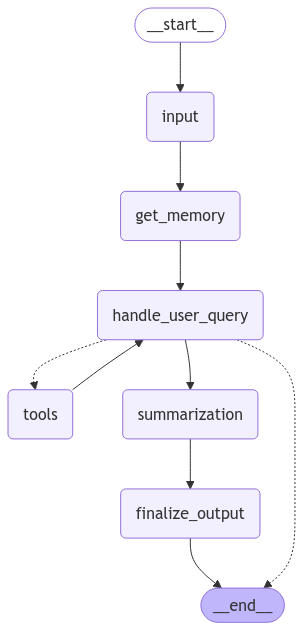

In [435]:
Image(agent.get_graph().draw_mermaid_png())

### TESTING SCENARIOIS


#### NEED REFERENCE MATERIALS FOR LEARNING?


In [96]:
config = {"configurable": {"thread_id": "1", "user_id": str(user_id)}}

In [436]:
config = {"configurable": {"thread_id": "313", "user_id": str(user_id)}}

stream_agent(
    agent=agent,
    config=config,
    input_value={"query": "I have given you a pdf about langchain, Can you tell me how large it is?"},
)

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[7].parameters.properties[v__kwargs].properties: should be non-empty for OBJECT type


In [437]:
agent.get_state(config).values

{'query': '',
 'messages': [HumanMessage(content='I have given you a pdf about langchain, Can you tell me how large it is?', additional_kwargs={}, response_metadata={}, id='cdd8e477-ed8c-406b-a4c5-6fe2153dc86b')],
 'memories': ''}

In [97]:
stream_agent(
    agent=agent,
    config=config,
    input_value={
        "query": "Hi, I am trying to Learn Langgraph, can you please find some reference material for me to get Started?"
    },
)

Okay, I found a few resources that should help you get started with Langgraph:

1.  **LangGraph Quickstart**: This tutorial from the official Langchain documentation guides you through building a chatbot that uses tools and keeps track of conversation history. It also covers human-in-the-loop capabilities and time-travel features.
    [https://langchain-ai.github.io/langgraph/tutorials/](https://langchain-ai.github.io/langgraph/tutorials/)
2.  **Introduction to LangGraph: A Beginner's Guide**: This article provides an overview of LangGraph's core concepts and includes simple examples to help beginners understand how to use it for building stateful applications with LLMs.
    [https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141](https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141)
3.  **Getting Started with LangGraph: A Practical Guide for Beginners**: This guide explains the basics of LangGraph, why it's useful, and how to set it up.
    [https://toxigon.com/getting-started-with-langgraph](https://toxigon.com/getting-started-with-langgraph)

These resources should provide a good starting point for learning Langgraph. Let me know if you have any other questions or need further assistance!


#### TESTING PERSISTANCE


In [98]:
config = {"configurable": {"thread_id": "1", "user_id": str(user_id)}}

In [99]:
stream_agent(
    agent=agent,
    config=config,
    input_value={"query": "Please Tell me what i said before"},
)

You previously asked me to find some reference material to help you get started with learning Langgraph.


#### TESTING MEMORY


In [119]:
config = {"configurable": {"thread_id": "5", "user_id": str(user_id)}}

In [120]:
stream_agent(
    agent=agent,
    config=config,
    input_value={"query": "Hi, I am Moosa and i love langgraph"},
)


Hi Moosa, it's great to hear from you again! I remember you mentioned that you love Langgraph. Is there anything specific you'd like to discuss or work on today related to Langgraph or any other topic?


In [121]:
config = {"configurable": {"thread_id": "111", "user_id": str(user_id)}}

In [122]:
stream_agent(
    agent=agent,
    config=config,
    input_value={"query": "What is my Name?"},
)

I'm sorry, but I don't have access to that information. Could you please share your name with me?


#### CREATING STUDY SCHEDULE


In [179]:
config = {"configurable": {"thread_id": "12", "user_id": str(user_id)}}

In [180]:
stream_agent(
    agent=agent,
    config=config,
    input_value={
        "query": "Hi, I Like python very much and have a python test upcoming on friday, please create a study schedule for me"
    },
)

Okay, I will create a study schedule for you based on your preferences. You have a Python test on Friday morning, you are available to study in the mornings, and you want to study for at most 3 hours each day. You want to cover all major topics in Python and prefer at least half-hour breaks between study sessions. You also want to include all days until the test from now.

Since today is December 28th, 2024, I will create a schedule for today, December 28th, 29th, 30th, 31st, and January 1st.

To make the schedule effective, I will allocate 3 hours each day with half-hour breaks between sessions. I will also include a mix of focused study and review sessions.

Here is the study schedule:

**Saturday, December 28th:**
*   **9:00 AM - 10:00 AM:** Focused Study - Python Basics (Data types, variables, operators)
*   **10:00 AM - 10:30 AM:** Break
*   **10:30 AM - 11:30 AM:** Focused Study - Control Structures (if, for, while loops)
*   **11:30 AM - 12:00 PM:** Break
*   **12:00 PM - 1:00 PM:** Review - Python Basics and Control Structures

**Sunday, December 29th:**
*   **9:00 AM - 10:00 AM:** Focused Study - Functions and Modules
*   **10:00 AM - 10:30 AM:** Break
*   **10:30 AM - 11:30 AM:** Focused Study - Working with Files
*   **11:30 AM - 12:00 PM:** Break
*   **12:00 PM - 1:00 PM:** Review - Functions, Modules, and File Handling

**Monday, December 30th:**
*   **9:00 AM - 10:00 AM:** Focused Study - Object-Oriented Programming (Classes, Objects)
*   **10:00 AM - 10:30 AM:** Break
*   **10:30 AM - 11:30 AM:** Focused Study - Exception Handling
*   **11:30 AM - 12:00 PM:** Break
*   **12:00 PM - 1:00 PM:** Review - OOP and Exception Handling

**Tuesday, December 31st:**
*   **9:00 AM - 10:00 AM:** Focused Study - Working with Libraries (e.g., NumPy, Pandas)
*   **10:00 AM - 10:30 AM:** Break
*   **10:30 AM - 11:30 AM:** Focused Study - Data Structures (Lists, Dictionaries, Tuples)
*   **11:30 AM - 12:00 PM:** Break
*   **12:00 PM - 1:00 PM:** Review - Libraries and Data Structures

**Wednesday, January 1st:**
*   **9:00 AM - 10:00 AM:** Practice - Solving coding problems
*   **10:00 AM - 10:30 AM:** Break
*   **10:30 AM - 11:30 AM:** Review - All topics
*   **11:30 AM - 12:00 PM:** Break
*   **12:00 PM - 1:00 PM:** Practice - Mock test

**Thursday, January 2nd:**
*   **9:00 AM - 10:00 AM:** Final Review - Quick review of all topics
*   **10:00 AM - 10:30 AM:** Break
*   **10:30 AM - 11:30 AM:** Practice - Mock test
*   **11:30 AM - 12:00 PM:** Break
*   **12:00 PM - 1:00 PM:** Relax and prepare for the test

I will now save this schedule to a markdown file.

Okay, I've created a study schedule for you, focusing on major Python topics and including breaks. The schedule is saved in `study_schedule.md`. Let me know if you need any adjustments!


In [181]:
agent.get_state(config).values

{'query': '',
 'response': AIMessage(content="Okay, I've created a study schedule for you, focusing on major Python topics and including breaks. The schedule is saved in `study_schedule.md`. Let me know if you need any adjustments!\n", additional_kwargs={}, response_metadata={'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probabili

In [182]:
stream_agent(
    agent=agent,
    config=config,
    input_value={"query": "Thats Great! Please save the schedule in a markdown file"},
)

I have already saved the schedule in a markdown file named `study_schedule.md`. Is there anything else I can help you with?
